In [41]:
# Dictionary used in the 2nd part to know the first and last frame of each ad
cut_ads = {
    "Quick": [52, 551],
    "Lipton": [561, 811],
    "Cegetel": [821, 1572],
    "Salveta": [1582, 2006],
    "VW Polo": [2016, 2765],
    "Kit Kat": [2775, 3276],
}

# List of the frames where there is a cut (used to compare the results of the algorithm)
cut_frames = [
    42,
    52,
    120,
    129,
    142,
    163,
    187,
    200,
    221,
    248,
    256,
    268,
    307,
    481,
    520,
    552,
    561,
    582,
    595,
    615,
    635,
    664,
    690,
    705,
    720,
    746,
    812,
    821,
    853,
    903,
    956,
    975,
    998,
    1027,
    1062,
    1099,
    1120,
    1144,
    1177,
    1220,
    1255,
    1293,
    1335,
    1367,
    1409,
    1573,
    1582,
    1655,
    1735,
    1812,
    1871,
    1895,
    1900,
    1909,
    1960,
    2007,
    2016,
    2106,
    2147,
    2184,
    2243,
    2487,
    2526,
    2617,
    2684,
    2766,
    2775,
    2808,
    2829,
    2858,
    2881,
    2917,
    2934,
    2962,
    2978,
    3011,
    3086,
    3179,
    3230,
    3277,
]


In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [43]:
def compare_results(results, cut_frames):
    false_positives = 0
    false_negatives = 0
    true_positives = 0
    for i in results:
        if i in cut_frames:
            true_positives += 1
        else:
            false_positives += 1
    for i in cut_frames:
        if i not in results:
            false_negatives += 1
    print(
        f"False positives: {false_positives}, False negatives: {false_negatives}, True positives: {true_positives}"
    )
    return false_positives, false_negatives, true_positives

# Partie 1

La difficulté dans une segmentation en plan et de trouver un bon indicateur de changement de plan. La plupart des algorithmes se basent sur des différences entre plusieurs images successives. Donc ce type d'analyse est changements brusques au sein d'un même plan, tel que un mouvement rapide de caméra, ou de luminosité. De plus, une transistion non brutale (tel que un fondu par exemple), peut passer innaperçu pour un tel algorithme.

In [44]:
### Lecture de la vidéo

filename = "Pub_C+_352_288_1.mp4"

video = cv2.VideoCapture(filename)
frameCount = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

fc = 0
ret = True

while (fc < frameCount-3  and ret):
    ret, buf[fc] = video.read()
    fc += 1
video.release()

def plot_frame(frame: np.ndarray):
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

***Fonctions pour la détection via les couleurs***

Pour quantifier l'information dans une image à partir des couleurs, on peut utiliser l'histogramme, comme présenté dans la fonction `histogram` ci-dessous.
La mesure de similarité proposé entre deux images à partir des couleurs et la distance de jaccard (Sa formule générale est $J(A,B) =\frac{\left|A \bigcap B\right|}{\left|A\bigcup B \right|}$). Ici, on calcule l'intersection des histogrammes en faisant la somme des minimums pour chaque intensité de couleur, et la somme des maximums pour l'union.

In [45]:
def jaccard_color(hist1:np.ndarray, hist2:np.ndarray) -> float:
    longueur = len(hist1)
    sommeMax = 0
    sommeMin = 0
    for i in range(longueur):
        sommeMax+=max(hist1[i][0], hist2[i][0])
        sommeMin+=min(hist1[i][0], hist2[i][0])
    return sommeMin/sommeMax


def histogram(frame: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Compute the histogram of a frame. Return a tuple of 3 histograms, one for each color."""
    hist_size = 256
    hist_range = (0, 256)

    hist_blue = cv2.calcHist(
        [frame], [0], None, [hist_size], hist_range, accumulate=False
    )
    hist_green = cv2.calcHist(
        [frame], [1], None, [hist_size], hist_range, accumulate=False
    )
    hist_red = cv2.calcHist(
        [frame], [2], None, [hist_size], hist_range, accumulate=False
    )
    return hist_blue, hist_green, hist_red


def distance_color(frame1:np.ndarray, frame2:np.ndarray) -> float:
    "Compute the distance between two frames using the color histograms."
    b1, g1, r1 = histogram(frame1)
    b2, g2, r2 = histogram(frame2)
    distance_blue = jaccard_color(b1, b2)
    distance_green = jaccard_color(g1, g2)
    distance_red = jaccard_color(r1, r2)
    return (distance_blue + distance_green + distance_red)/3


def distance_color_array(frames: np.ndarray) -> np.ndarray[np.float64]:
    """Return an array of distances between each consecutive frame of a video, based on the color histograms."""
    distances = np.zeros((len(frames) - 1), dtype=float)
    for i in range(len(frames) - 1):
        distances[i]= distance_color(frames[i], frames[i + 1])
    return distances

***Fonctions pour la détection via les contour***

La quantifcation de l'information via les contours se fait grâce à la fonction `findContours` de openCV (https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html). La méthode RETR_TREE utilisée change juste la hiérarchie avec laquelle sont présentée les contours trouvés, information qui ne nous intéresse pas (https://docs.opencv.org/4.x/d9/d8b/tutorial_py_contours_hierarchy.html).
On utilise aussi la distance de Jaccard pour calculer la similarité, en regardant pour chaque pixel des deux images s'il fait partie d'un contour sur les images.

In [46]:
def jaccard_contour(frame1:np.ndarray, frame2:np.ndarray) -> float:
    """Compute the jaccard distance between two binary images"""
    inter = np.logical_and(frame1, frame2)
    union = np.logical_or(frame1, frame2)
    compteur_inter = np.count_nonzero(inter)
    compteur_union = np.count_nonzero(union)
    return compteur_inter/compteur_union
    

def compute_contour(frame:np.ndarray) -> np.ndarray:
    """Compute the contour of a frame"""
    imgray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
                                    
    # draw contours on the original image
    image_copy = np.zeros(frame.shape,dtype=np.uint8)
    cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(255, 255, 255), thickness=3, lineType=cv2.FILLED)
    im_contour = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
    return im_contour > 5


def distance_contour(frame1:np.ndarray, frame2:np.ndarray) -> float:
    """Compute the distance between two frames using the contours."""
    try:
        contour1 = compute_contour(frame1)
        contour2 = compute_contour(frame2)
        shape_match = jaccard_contour(contour1, contour2)
        return shape_match
    except:
        return 0


def distance_contour_array(frames: np.ndarray) -> np.ndarray[np.float64]:
    """Return an array of distances between each consecutive frame of a video, based on the contours."""
    distances = np.zeros((len(frames) - 1), dtype=float)
    for i in range(len(frames) - 1):
        distances[i]= distance_contour(frames[i], frames[i + 1])
    return distances


On peut juger une mesure selon :
- Précision : Capacité à identifier uniquement les changements réels de plans.
- Rappel : Capacité à identifier tous les changements de plans.
- Robustesse : Résistance aux variations non significatives (bruit, transitions douces).
- Vitesse : Temps de calcul pour le traitement vidéo.

La mesure utilisant à l'avantage d'être simple, mais elle est cependant sensible aux changements non significatifs, tel que l'éclairage, ou un mouvement rapide de caméra.
La mesure utilisant les contours n'est pas sensible aux variations de couleurs, mais elle est plus longue à calculer.

In [47]:
def smooth_array(distances:np.ndarray, window_size:int) -> tuple[np.ndarray, np.ndarray]:
    """Smooths an array of distances using a moving average with a specified window size and calculates the standard deviation for each window."""
    end = len(distances) - (window_size//2+window_size%2)
    smoothed = np.zeros((end), dtype=float)
    standard_deviation = np.zeros((end), dtype=float)
    for i in range(window_size//2, len(distances) - (window_size//2+window_size%2)):
        distances_window = distances[i - window_size//2 : i + (window_size//2+window_size%2)]
        smoothed[i] = sum(distances_window) / window_size
        standard_deviation[i] = np.std(distances_window)
    return smoothed, standard_deviation


def detect_changes(distances:np.ndarray, threshold:np.ndarray):
    """Detect the first frame of each shot"""
    changes = []
    for i in range(len(threshold)-1):
        if distances[i] < threshold[i]:
            changes.append(i+1)
    return changes

***Résultats en utilisant la méthode via les couleurs***

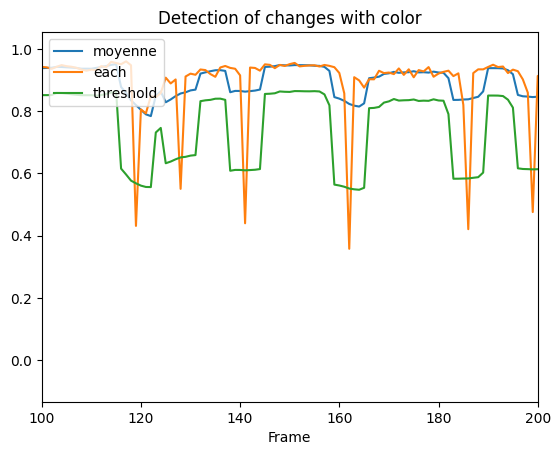

False positives: 0, False negatives: 8, True positives: 72
Recall: 0.9, Precision: 1.0


In [48]:
distances = distance_color_array(buf)
smoothed, standard_deviation = smooth_array(distances, 7)
error = 0.08
thresh = np.array(smoothed) - np.array(standard_deviation) - error
changes = detect_changes(distances, thresh)


plt.plot(smoothed, label="moyenne")
plt.plot(distances, label="each")
plt.plot(thresh, label="threshold")
plt.xlabel("Frame")
plt.legend(loc="upper left")
plt.title("Detection of changes with color")
plt.xlim(100, 200)
plt.show()

false_positives, false_negatives, true_positives = compare_results(changes, cut_frames)
recall = true_positives / (true_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)
print(f"Recall: {recall}, Precision: {precision}")

***Résultats en utilisant la méthode via les contour***

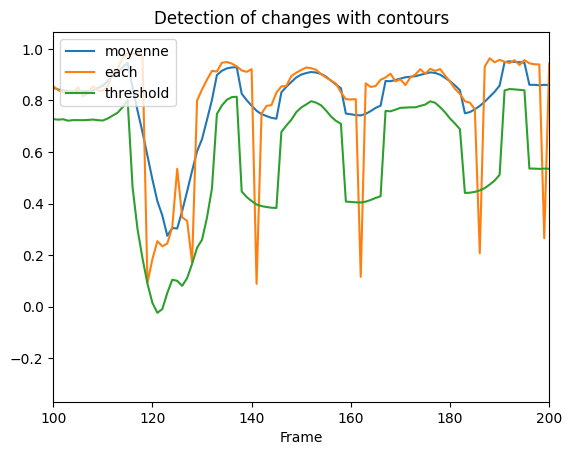

False positives: 4, False negatives: 15, True positives: 65
Recall: 0.8125, Precision: 0.9420289855072463


In [49]:
distances_contour = distance_contour_array(buf)
smoothed_contour, standard_deviation_contour = smooth_array(distances_contour, 8)
error = 0.1
threshold_contour = np.array(smoothed_contour) - np.array(standard_deviation_contour) - error
changes_contour = detect_changes(distances_contour, threshold_contour)


plt.plot(smoothed_contour, label="moyenne")
plt.plot(distances_contour, label="each")
plt.plot(threshold_contour, label="threshold")
plt.xlabel("Frame")
plt.title("Detection of changes with contours")
plt.legend(loc="upper left")
plt.xlim(100, 200)
plt.show()

false_positives, false_negatives, true_positives = compare_results(changes_contour, cut_frames)
recall = true_positives / (true_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)
print(f"Recall: {recall}, Precision: {precision}")

On obtient ici un meilleur résultat avec la méthode utilisant les couleurs.

# Partie 2

Un marqueur de séquence vidéo consiste en 2 informations: une image représentative de la séquence, et la différence temporelle avec la prochaine image représentative.

Une image représentative peut être déterminée de plusieurs manières. Nous en proposons deux dans ce projet.
La première méthode utilise les histogrammes de couleurs pour déterminer l'image représentative. En calculant l'histogramme moyen sur une séquence, il est possible de trouver l'image ayant l'histogramme se rapprochant le plus de ce dernier, et utiliser cette image comme image représentative.
La deuxième méthode utilise les contours, et par d'un postulat simple. Si la caméra reste longtemps fixe, c'est que cette partie de la séquence est d'intérêt. Si l'on calcule la moyenne des distances à partir des contours sur une partie de séquence, et que cette moyenne est basse, c'est donc que la caméra bouge peu sur cette partie de séquence. On peut alors garder l'image au centre de cette partie de séquence afin de l'utiliser comme image représentative de la séquence.
Une fois les images représentatives trouvées, on peut créer une liste contenant les marqueurs, à savoir les couples images représentatives / Delta temporel avec la prochaine image.

La méthode pour détecter une séquence dans une vidéo est alors la suivante :
 
- La première image représentative est comparée aux différentes images de la vidéo. Le critère de proximité est libre d'être choisi. La moyenne des écarts pixel par pixel ne fonctionne pas bien car très sensible à des changements de luminosité par exemple. Nous avons décidé de choisir l'écart type de ces différences, qui doit être très faible pour des images similaires malgré une différence de luminosité.
- Dès que l'on trouve une image proche de l'image représentative, on va comparer les différentes images représentatives avec les images de notre vidéo espacées des mêmes temps que les images représentatives. Nous avons décidé de comparer uniquement aux trois premières images représentatives car les résultats étaient déjà excellents tout en gardant un temps de calcul faible.
- Si ces écarts aux différentes images représentatives sont faibles, c'est que l'on a trouvé notre séquence.
- Si à un moment, la comparaison avec une image représentative ne renvoie pas une proximité faible, on continue de balayer les images de la vidéo et de les comparer à la première image représentative afin de répéter le processus.

Pour implémenter cette méthode, les marqueurs sont déterminés à l'avance et sont stockées dans une base de donnée. L'algorithme utilise alors cette base de donnée pour appliquer la méthode à n'importe quelle vidéo souhaitée.

***Get the reference frames and then the signature for each ad using the mean histogram of each shot***

In [50]:
def distance_between_hist(hist1, hist2):
        b1, g1, r1 = hist1
        b2, g2, r2 = hist2
        distance_blue = jaccard_color(b1, b2)
        distance_green = jaccard_color(g1, g2)
        distance_red = jaccard_color(r1, r2)
        return (distance_blue + distance_green + distance_red)/3

def mean_histogram(video, frame_begin, frame_end):
    mean_hist = np.zeros((3, 256, 1))
    for i in range(frame_begin, frame_end+1):
        mean_hist = mean_hist + histogram(video[i])
    return mean_hist/(frame_end+1-frame_begin)


def detect_best_frame(video, frame_begin, frame_end):
    mean_hist = mean_histogram(video, frame_begin, frame_end)
    best_index = frame_begin
    best_dist = 0
    for i in range(frame_begin, frame_end + 1):
        hist = histogram(video[i])
        dist = distance_between_hist(hist, mean_hist)
        if dist > best_dist:
            best_index = i
            best_dist = dist
    return best_index
        
    
def get_best_frames(video, cut_frames:list, cut_ads:dict):
    best_frames = {"other":[]}
    for key in cut_ads.keys():
        best_frames[key] = []
    
    for i in range(len(cut_frames)-1):
        frame = detect_best_frame(video, cut_frames[i], cut_frames[i+1]-1)

        is_added = False
        for key, item in cut_ads.items():
            if frame >= item[0] and frame <= item[1]:
                best_frames[key].append(frame)
                is_added = True
        
        if not is_added:
            best_frames["other"].append(frame)
        
    return best_frames


In [106]:
def get_signature(frames, video):
    frames_and_delta = []
    for i in range (0, len(frames)-1):
        frames_and_delta.append((video[frames[i]], frames[i+1] - frames[i]))
    return frames_and_delta

def resize_signature(signature, size):
    new_signature = []
    for frame, delta in signature:
        new_signature.append((cv2.resize(frame, size, interpolation = cv2.INTER_LINEAR), delta))
    return new_signature

***Get the reference frames and then the signature for each ad using the stillness of a frame compared to the ones around it***

In [52]:
def get_stillness(batch_distances):
    return sum(batch_distances)/len(batch_distances)
    

def get_still_moment(distances_c, frame_begin, frame_end, batch_size):
    still_index = frame_begin
    best_stillness = 0
    if frame_end - batch_size + 1 <= frame_begin:
        return frame_begin
    for i in range (frame_begin, frame_end - batch_size + 2):
        batch_distances = distances_c[i:i+batch_size]
        stillness = get_stillness(batch_distances)
        if stillness > best_stillness:
            still_index = i
            best_stillness = stillness
            
    return still_index

def get_best_frames_contours(video, cut_frames:list, cut_ads:dict, batch_size):
    distances_c = distance_contour_array(video)
    best_frames = {"other":[]}
    for key in cut_ads.keys():
        best_frames[key] = []

    for i in range(len(cut_frames)-1):
        frame = get_still_moment(distances_c, cut_frames[i], cut_frames[i+1]-1, batch_size)

        is_added = False
        for key, item in cut_ads.items():
            if frame >= item[0] and frame <= item[1]:
                best_frames[key].append(frame)
                is_added = True

        if not is_added:
            best_frames["other"].append(frame)

    return best_frames

***Reference frames and signature using the histogram methods***

In [53]:
best_frames_histogram = get_best_frames(buf, changes, cut_ads)
signature_ad_histogram = get_signature(best_frames_histogram['Lipton'], buf)
print(best_frames_histogram)

{'other': [44, 556, 816, 1577, 2012, 2771], 'Quick': [81, 123, 133, 151, 175, 191, 208, 231, 252, 261, 290, 481], 'Lipton': [569, 586, 610, 624, 650, 680, 695, 713, 729, 784], 'Cegetel': [830, 875, 929, 965, 986, 1008, 1044, 1079, 1107, 1129, 1160, 1217, 1232, 1288, 1324, 1362, 1428], 'Salveta': [1614, 1696, 1758, 1827, 1878, 1927], 'VW Polo': [2093, 2129, 2167, 2227, 2419, 2517, 2570, 2762], 'Kit Kat': [2792, 2814, 2842, 2874, 2903, 2924, 2948, 2969, 2990, 3050, 3113, 3228]}


***Reference frames and signature using the stillness methods***

In [54]:
best_frames_stillness = get_best_frames_contours(buf, changes, cut_ads, batch_size=10)
signature_ad_stillness = get_signature(best_frames_stillness['Lipton'], buf)
print(best_frames_stillness)

{'other': [42, 552, 812, 1573, 2007, 2766], 'Quick': [64, 120, 131, 148, 170, 188, 207, 234, 248, 256, 282, 540], 'Lipton': [562, 584, 604, 623, 653, 678, 694, 709, 735, 792], 'Cegetel': [829, 885, 917, 956, 983, 1002, 1051, 1074, 1106, 1130, 1166, 1209, 1230, 1278, 1323, 1340, 1561], 'Salveta': [1644, 1655, 1740, 1814, 1884, 1995], 'VW Polo': [2080, 2133, 2149, 2208, 2332, 2493, 2605, 2755], 'Kit Kat': [2787, 2808, 2829, 2869, 2893, 2920, 2949, 2962, 2995, 3068, 3115, 3261]}


***Getting the test video***

In [101]:
# filename_test = "Pub_C+_352_288_2_.mp4"
filename_test = "Pub_C+_176_144.mp4"

video_test = cv2.VideoCapture(filename_test)
frameCount_test = int(video_test.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth_test = int(video_test.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight_test = int(video_test.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(frameCount_test, frameWidth_test, frameHeight_test)

buf_test = np.empty((frameCount_test, frameHeight_test, frameWidth_test, 3), np.dtype('uint8'))

fc = 0
ret = True

while (fc < frameCount_test-3  and ret):
    ret, buf_test[fc] = video_test.read()
    fc += 1
video_test.release()


3289 176 144


***Functions to check if an ab is in the video and where***

In [ ]:
def similarity_frames(frame1, frame2):
    diff = frame1 - frame2
    return np.std(diff)
    
def are_frames_similar(signature, video, first_index, threshold):

    first_frames_distance = similarity_frames(signature[0][0], video[first_index])
    if 540 < first_index < 580:
        print(first_index, first_frames_distance)
    if first_frames_distance < threshold:
        delta = signature[0][1]
        second_index = first_index+delta
        if second_index > len(video):
            return False
        second_frames_distance = similarity_frames(signature[1][0], video[second_index])
        if second_frames_distance < threshold:
            delta = signature[1][1]
            third_index = second_index+delta
            if third_index > len(video):
                return False
            third_frames_distance = similarity_frames(signature[2][0], video[third_index])
            if third_frames_distance < threshold:
                return first_frames_distance
    return False

def is_same_ad_inside(signature, video_test, threshold):

    signature_size = signature[0][0].shape
    video_test_size = video_test[0].shape

    print(signature_size, video_test_size)

    if signature_size != video_test_size:
        signature = resize_signature(signature, (video_test_size[1], video_test_size[0]))
    
    # print(signature)
    plot_frame(signature[0][0])
    plot_frame(video_test[568])
    
    # print(signature[0][0].shape, video_test[0].shape)

    for i in range (len(video_test)):
        if are_frames_similar(signature, video_test, i, threshold):
            print(are_frames_similar(signature, video_test, i, threshold))
            return i
    return False

***Results with specific pub***

(288, 352, 3) (144, 176, 3)


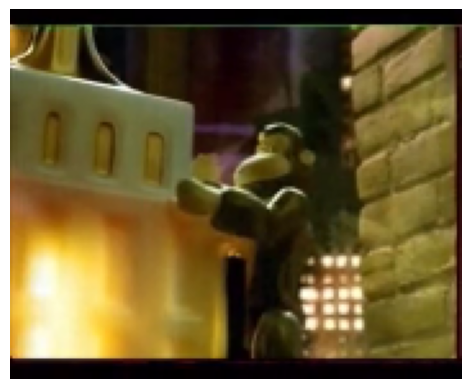

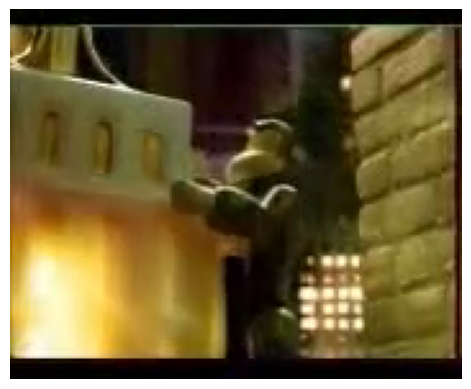

0 86.51433251444632
1 86.49007651158604
2 86.45465865416429
3 86.48424140003884
4 86.4821615050739
5 86.48398617953326
6 86.4576611188008
7 86.4533045307837
8 86.4785588859895
9 86.46772345731482
10 86.46124541727508
11 86.45134075299208
12 86.38939422337708
13 86.39378445545833
14 86.38409972655732
15 86.40407748977285
16 86.39303561263621
17 86.41238526502295
18 86.40520576684197
19 86.40360235710158
20 86.40508650354077
21 86.4377260839904
22 86.4180447831639
23 86.41280602190746
24 86.36509631883159
25 86.3711539301372
26 86.36545760308947
27 86.37274118632213
28 86.36631220047343
29 86.4039291172935
30 86.39919094353895
31 86.34864066421721
32 86.38526147952277
33 86.39686435745945
34 86.34934760145188
35 86.41133470113886
36 86.3539297121833
37 86.35572824767871
38 86.38278157502293
39 86.36166044298535
40 86.37290599376473
41 86.52303058770147
42 78.28879752013438
43 78.33885853931623
44 78.50445108207609
45 78.3679954009773
46 78.2957835062913
47 78.09524898836807
48 78.0165020

In [109]:
signature_Lipton_color = get_signature(best_frames_histogram['Lipton'], buf)
frame_of_ad = is_same_ad_inside(signature_Lipton_color, buf_test, 40)
print(best_frames_histogram['Lipton'][0], frame_of_ad)
# plt.figure,
# plt.imshow(cv2.cvtColor(buf[best_frames_histogram['Lipton'][0]], cv2.COLOR_BGR2RGB))
# plt.axis("off")
# plt.title(f"Première image caractéristique dans la base de données pou la pub Lipton (frame {best_frames_histogram['Lipton'][0]})")
# plt.show()

# print(frame_of_ad)

# plt.figure,
# plt.imshow(buf_test[frame_of_ad])
# plt.axis("off")
# plt.title(f"Première image caractéristique de la pub Lipton trouvée (frame {frame_of_ad})")
# plt.show()

L'algorithme a trouvé quasimement la même frame (1 de décalage). On obtient donc un résultat satisfaisant.